In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from umap import UMAP
import numpy as np
import pandas as pd
import torch

from counterfactuals.datasets import HelocDataset
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)

from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.plot_utils import (
    plot_classifier_decision_region,
    plot_generative_model_distribution,
    plot_observations,
    plot_counterfactuals,
    plot_arrows,
)
from counterfactuals.cf_methods import RPPCEF
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.metrics import evaluate_cf

torch.manual_seed(0)

/Users/ofurman/Study/counterfactuals/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot(
    ax, flow, disc_model, dataset, X_test, y_test, X_cf, prob_threshold, colors=None
):
    assert (
        X_test.shape == X_cf.shape
    ), f"Sizes of test set and counterfactuals are not equal. Actual sizes: X_test: {X_test.shape}, X_cf: {X_cf.shape}"
    assert (
        y_test.shape[0] == X_cf.shape[0]
    ), f"Sizes of targets and counterfactuals are not equal. Actual sizes: X_cf: {X_cf.shape}, y_test: {y_test.shape}"

    ax = plot_classifier_decision_region(ax, disc_model)
    ax = plot_generative_model_distribution(
        ax,
        flow,
        prob_threshold=prob_threshold,
        num_classes=len(np.unique(dataset.y_test)),
    )
    ax = plot_observations(ax, X_test, y_test, colors)
    ax = plot_counterfactuals(ax, X_cf)
    ax = plot_arrows(ax, X_test, X_cf)
    # ax = plot_metrics_textbox(ax, metrics)
    return ax

In [ ]:
dataset = HelocDataset(file_path="../data/heloc.csv")

disc_model_name = "MultilayerPerceptron"
disc_model = MultilayerPerceptron(
    input_size=dataset.X_test.shape[1],
    hidden_layer_sizes=[512, 256, 256],
    target_size=1,
)
# disc_model.fit(
#     dataset.train_dataloader(128, shuffle=True),
#     test_loader=dataset.test_dataloader(1024, shuffle=False),
#     epochs=1000,
#     lr=1e-3,
#     patience=100,
#     checkpoint_path="mlp.pth"
# )


disc_model.load("mlp.pth")
disc_model.eval()
y_pred = disc_model.predict(dataset.X_test).numpy().flatten()
print(y_pred, dataset.y_test)
print(f"Accuracy: {np.mean(y_pred == dataset.y_test)}")

# disc_model.load(f"../models/HelocDataset/disc_model_{disc_model_name}.pt")

dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.fit(
    dataset.train_dataloader(1024, shuffle=True, noise_lvl=0.02),
    test_loader=dataset.test_dataloader(1024, shuffle=False),
    num_epochs=1000,
    checkpoint_path="flow.pth",
)
flow.load("flow.pth")
flow.eval()
log_prob_threshold = torch.quantile(
    flow.predict_log_prob(dataset.train_dataloader(1024, shuffle=False)), 0.25
)
log_prob_threshold

# dataset.X_test = dataset.X_train
# dataset.y_test = dataset.y_train

origin_class = 0
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test == origin_class]
y_test_origin = dataset.y_test[dataset.y_test == origin_class]
X_test_target = dataset.X_test[dataset.y_test == target_class]
y_test_target = dataset.y_test[dataset.y_test == target_class]


method_mapping = {
    "ARES": "GCE",
    "GLOBAL_CE": "GCE w/ magnitude",
    "GCE": "Our",
    "PPCEF_2": "Wachter",
}

metrics_df = pd.DataFrame(
    columns=[
        "model_returned_smth",
        "valid_cf_disc",
        "dissimilarity_proximity_categorical_hamming",
        "dissimilarity_proximity_categorical_jaccard",
        "dissimilarity_proximity_continuous_manhatan",
        "dissimilarity_proximity_continuous_euclidean",
        "dissimilarity_proximity_continuous_mad",
        "distance_l2_jaccard",
        "distance_mad_hamming",
        "sparsity",
        "flow_log_density_cfs",
        "flow_log_density_xs",
        "flow_prob_condition_acc",
        "lof_scores_xs",
        "lof_scores_cfs",
        "isolation_forest_scores_xs",
        "isolation_forest_scores_cfs",
        "plausibility",
        "cf_belongs_to_group",
        "K_vectors",
    ]
)

plausibility = {0: "plaus", 1: "no_plaus"}
plausibility_mapping = {"plaus": "w/ PP.", "no_plaus": "w/o PP."}

alpha = 10000
alpha_s = 10000
alpha_k = 10000
print(f"alpha: {alpha}, alpha_s: {alpha_s}, alpha_k: {alpha_k}")

K = X_test_origin.shape[0]
K = 6
cf = RPPCEF(
    N=X_test_origin.shape[0],
    D=X_test_origin.shape[1],
    K=K,
    cf_method_type="GCE",
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)

cf_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test_origin).float(),
        torch.tensor(y_test_origin).float(),
    ),
    batch_size=4096,
    shuffle=False,
)

delta, Xs, ys_orig, ys_target, _ = cf.explain_dataloader(
    dataloader=cf_dataloader,
    epochs=20_000,
    lr=3e-3,
    patience=500,
    alpha=alpha,
    alpha_s=alpha_s,
    alpha_k=0,
    log_prob_threshold=log_prob_threshold,
)

M, S, D = delta.get_matrices()
M = M.detach().numpy()
S = S.detach().numpy()
D = D.detach().numpy()

X_cf = Xs + delta().detach().numpy()

In [9]:
metrics = evaluate_cf(
    gen_model=flow,
    disc_model=disc_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]).astype(bool),
    categorical_features=dataset.categorical_features,
    continuous_features=dataset.numerical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train.reshape(-1),
    X_test=Xs,
    y_test=ys_orig,
    median_log_prob=log_prob_threshold,
    S_matrix=S,
    X_test_target=X_test_target,
)

# save metrics dict to json
metrics_df = pd.concat(
    [metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True
)
metrics
# metrics_df.to_csv(f"metrics_groups_alpha_{alpha}_alpha_s_{alpha_s}_alpha_k_{alpha_k}.csv")

/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_11281/4234898549.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame().from_dict([metrics])], ignore_index=True)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [43]:
umap = UMAP(n_components=2)
umap.fit(dataset.X_train)
X_test_umap = umap.transform(Xs)
X_cf_umap = umap.transform(X_cf)

In [44]:
y_pred_cf = disc_model.predict(X_cf).detach().numpy().flatten()
filters = (y_pred_cf == ys_target.flatten()) & (S.max(axis=1) == 1)

X_cf_filtered = X_cf[filters]
Xs_filtered = Xs[filters]
Xs_filtered_umap = X_test_umap[filters]
X_cf_filtered_umap = X_cf_umap[filters]
ys_orig_filtered = ys_orig[filters]
S_filtered = S[filters]
group_labels = S_filtered.argmax(axis=1)

In [45]:
cols = list(pd.read_csv("../data/heloc.csv").columns)[1:]

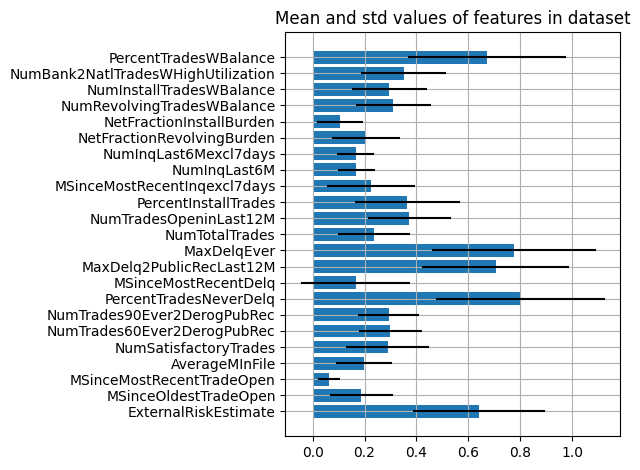

In [63]:
# plot barplot with mean and std of each feature
fig, ax = plt.subplots(1, 1)
mean = Xs_filtered.mean(axis=0)
std = Xs_filtered.std(axis=0)
ax.barh(cols, mean, xerr=std, align="center")
plt.title("Mean and std values of features in dataset")
plt.tight_layout()
plt.grid()

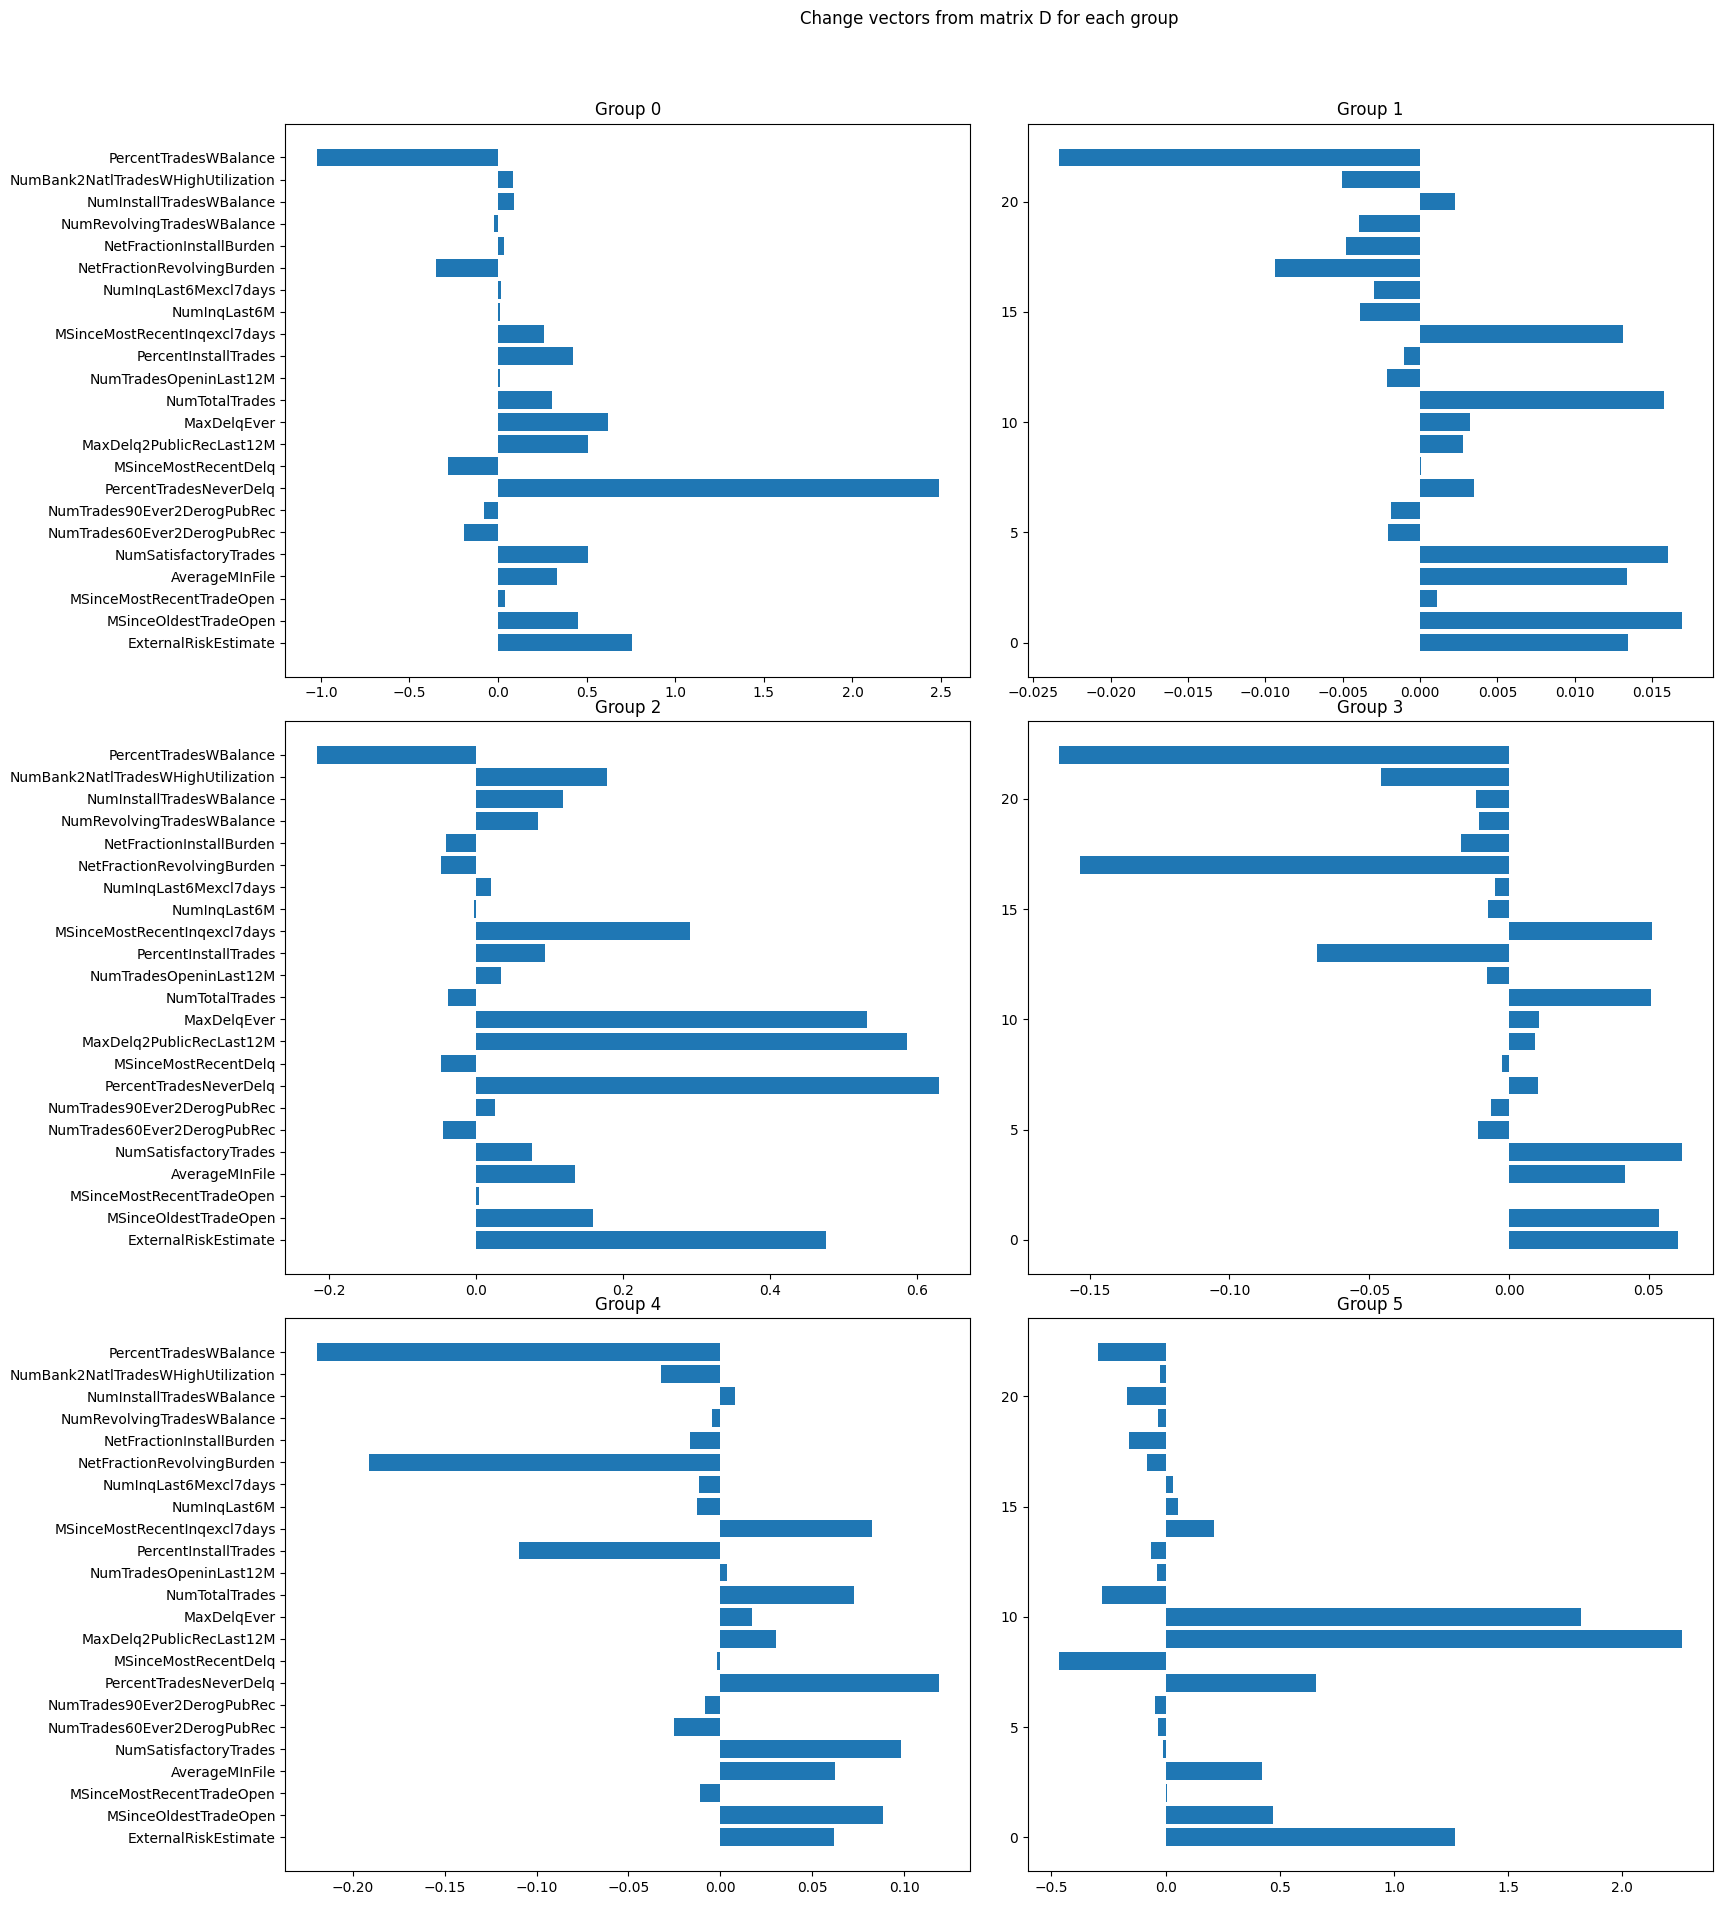

In [69]:
# plot barplot with mean and std of each feature
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
fig.suptitle("Change vectors from matrix D for each group")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 3):
    for j in range(0, 2):
        group = i * 2 + j
        ax[i, j].barh(cols if j == 0 else range(len(cols)), D[group], align="center")
        ax[i, j].set_title(f"Group {group}")

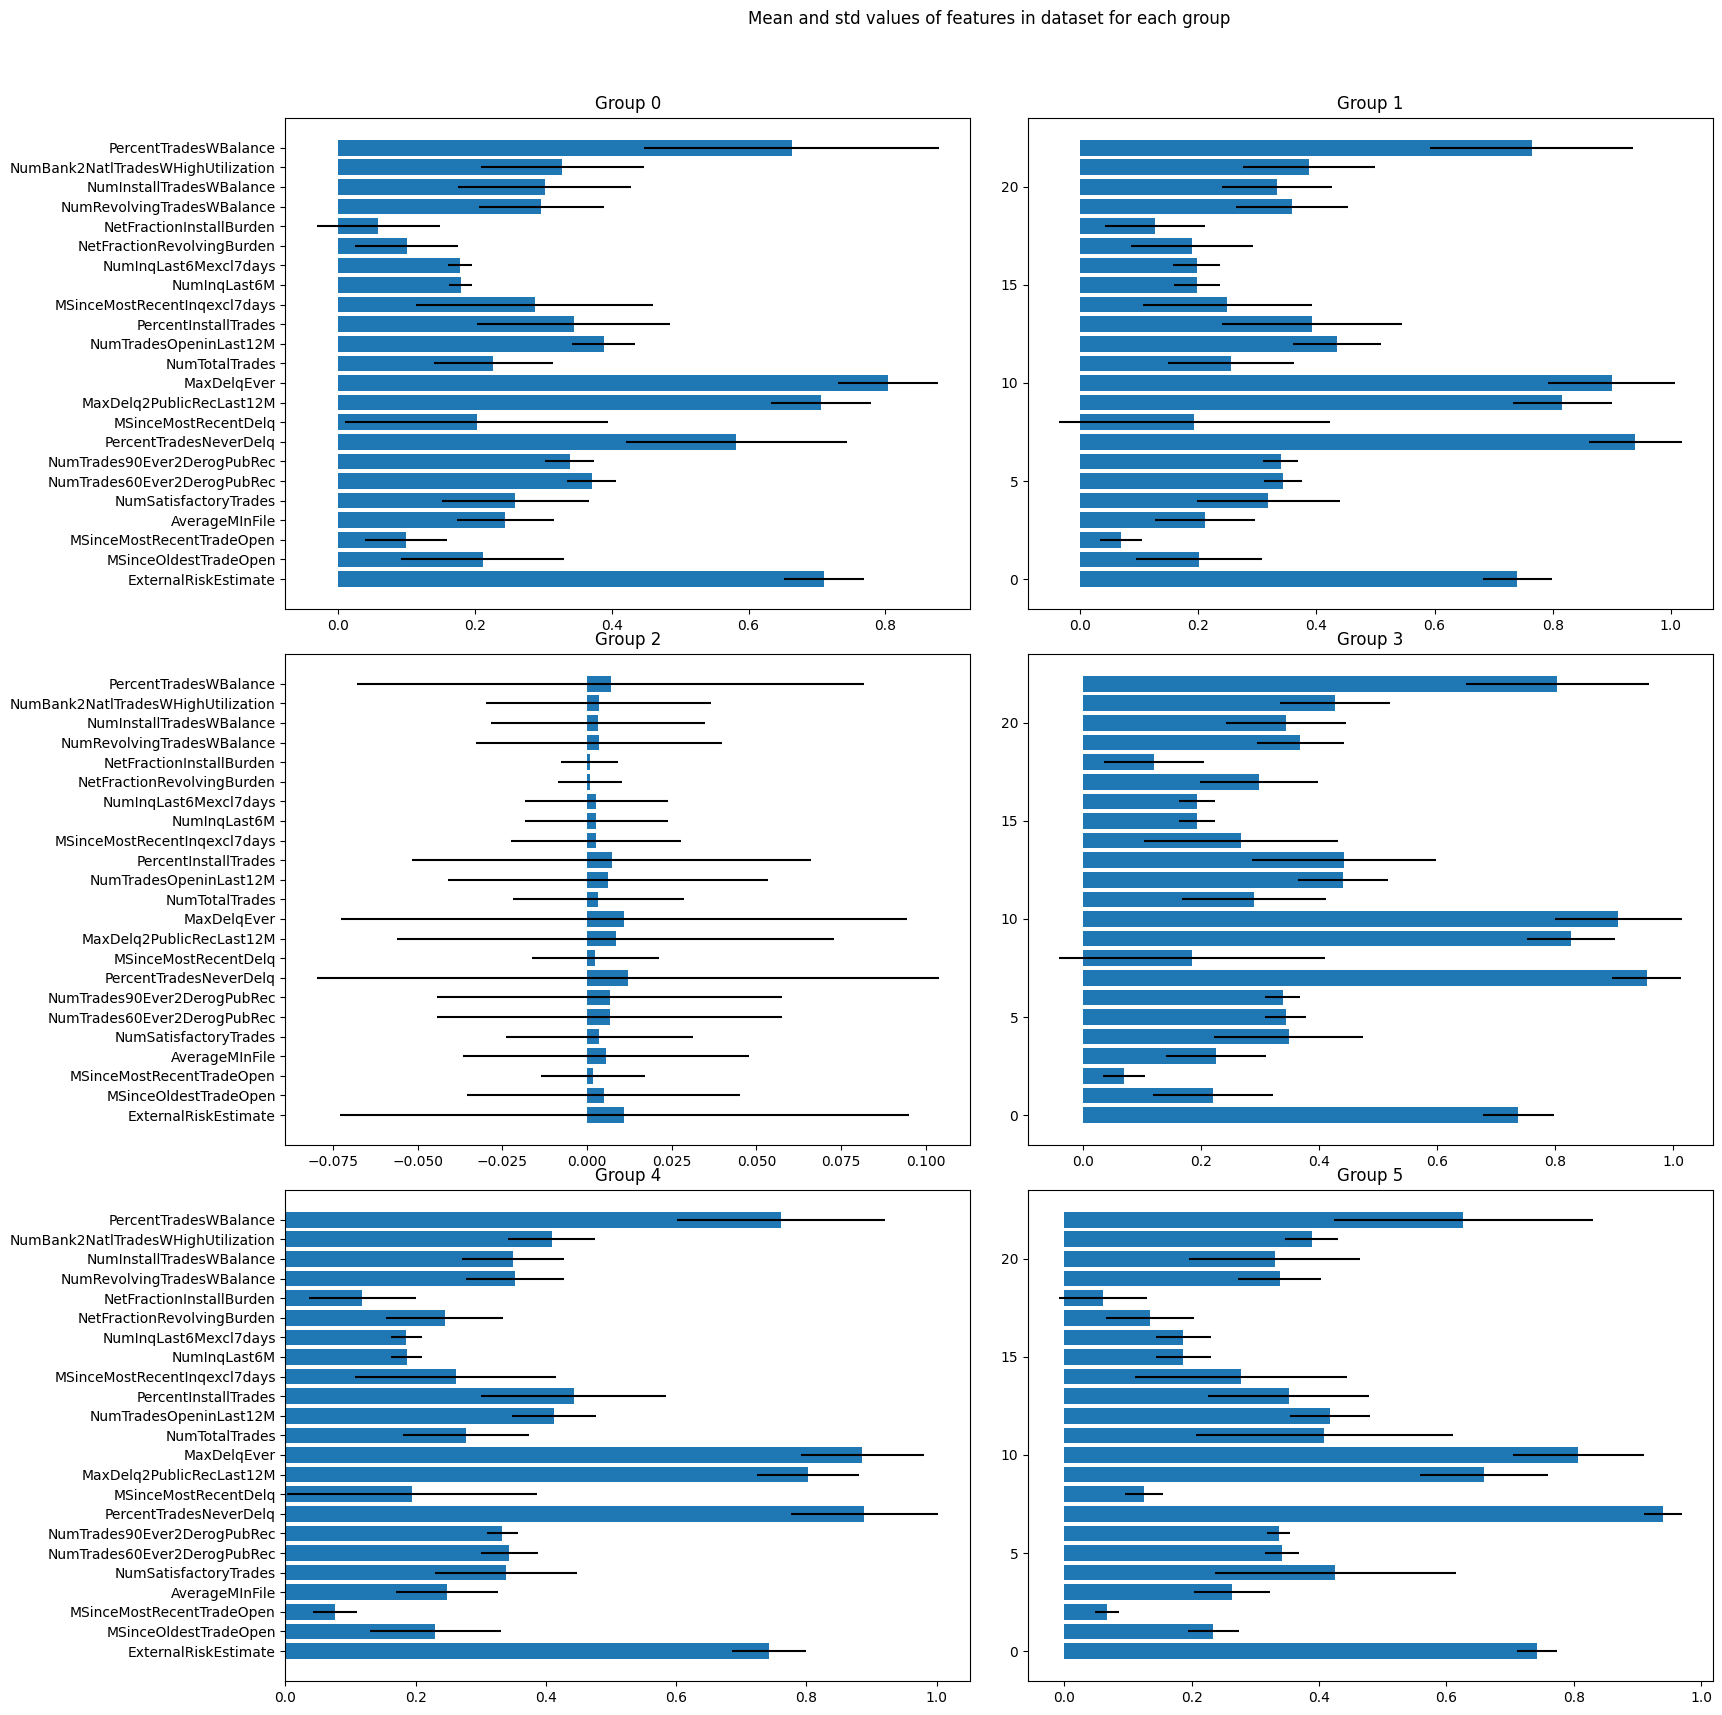

In [70]:
fig, ax = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle("Mean and std values of features in dataset for each group")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 3):
    for j in range(0, 2):
        group = i * 2 + j
        mean = Xs_filtered[group_labels == group].mean(axis=0)
        std = np.abs(Xs_filtered[group_labels == group].std(axis=0))
        ax[i, j].barh(
            cols if j == 0 else range(len(cols)), mean, xerr=std, align="center"
        )
        ax[i, j].set_title(f"Group {group}")

In [71]:
# fig, ax = plt.subplots(3, 2, figsize=(20, 25))
# for i in range(0, 3):
#     for j in range(0, 2):
#         group = i * 2 + j
#         mean = Xs_filtered[group_labels == group].mean(axis=0) - Xs_filtered.mean(axis=0)
#         mean = Xs_filtered[group_labels == group].mean(axis=0) - Xs_filtered.mean(axis=0)
#         ax[i, j].barh(cols if j == 0 else range(len(cols)), mean, xerr=std, align="center")

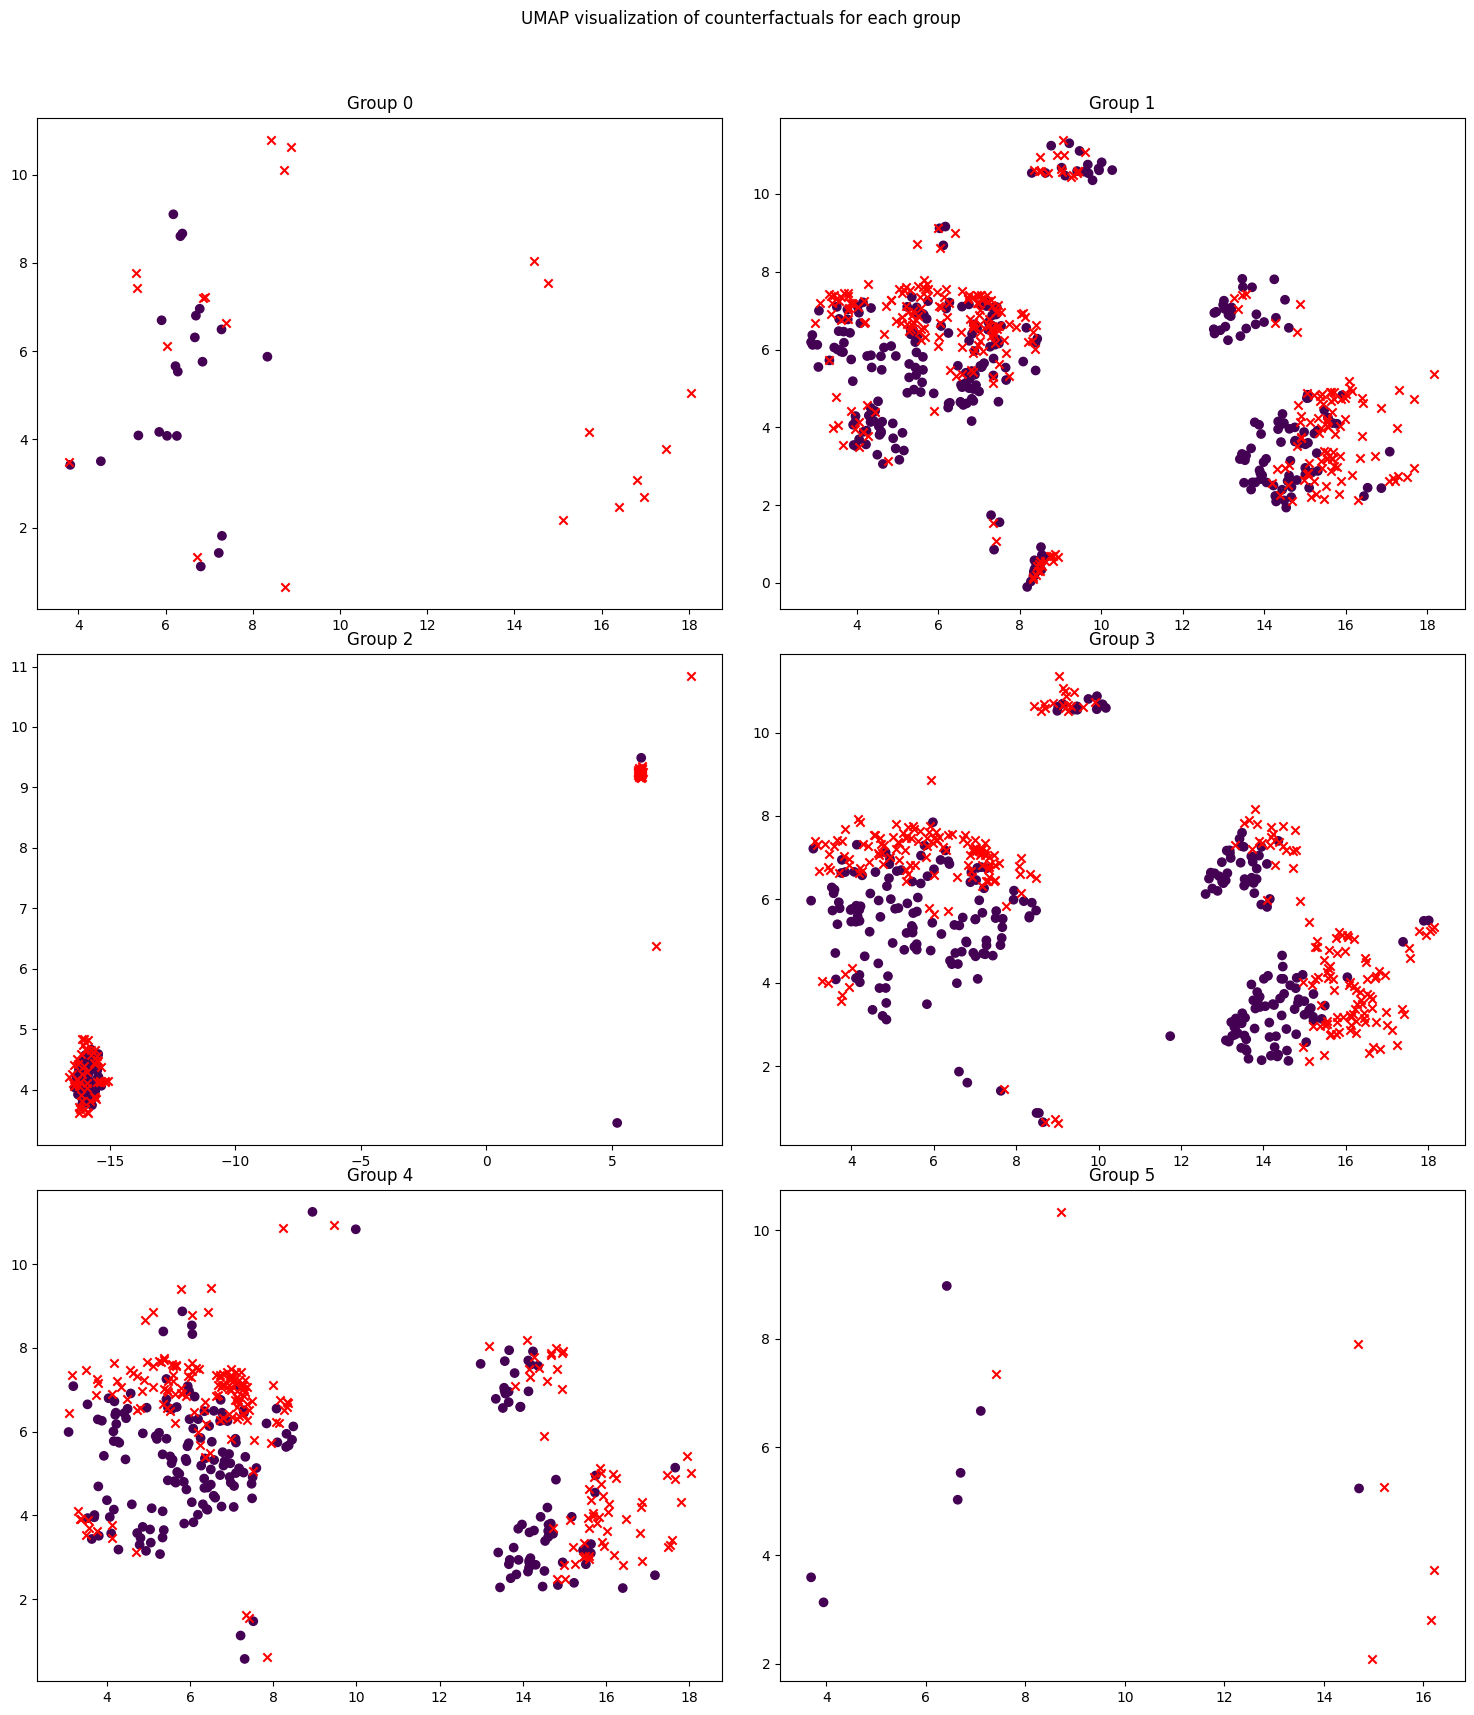

In [72]:
fig, ax = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle("UMAP visualization of counterfactuals for each group")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i in range(0, 3):
    for j in range(0, 2):
        group = i * 2 + j
        ax[i, j].scatter(
            Xs_filtered_umap[group_labels == group, 0],
            Xs_filtered_umap[group_labels == group, 1],
            c=group_labels[group_labels == group],
        )
        ax[i, j].scatter(
            X_cf_filtered_umap[group_labels == group, 0],
            X_cf_filtered_umap[group_labels == group, 1],
            c="red",
            marker="x",
        )
        ax[i, j].set_title(f"Group {group}")

(6, 2)


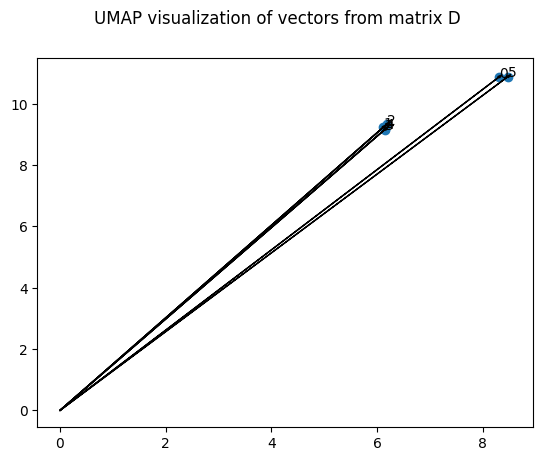

In [74]:
# plot vectors from D matrix as arrows in 2D space alongside with index of the vector
D_umap = umap.transform(D)
print(D_umap.shape)

fig, ax = plt.subplots(1, 1)
fig.suptitle("UMAP visualization of vectors from matrix D")
ax.scatter(D_umap[:, 0], D_umap[:, 1])
for i, txt in enumerate(range(D.shape[0])):
    ax.annotate(txt, (D_umap[i, 0], D_umap[i, 1]))

for i in range(D.shape[0]):
    ax.arrow(0, 0, D_umap[i, 0], D_umap[i, 1], head_width=0.05, head_length=0.1)

plt.show()

In [75]:
M

array([[7.1589155],
       [3.5304818],
       [0.8850864],
       ...,
       [0.8884115],
       [1.9351254],
       [0.7915811]], dtype=float32)

<BarContainer object of 6 artists>

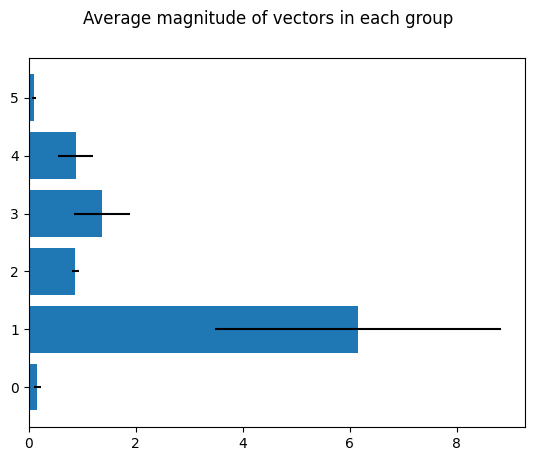

In [86]:
mean_magnitudes = []
std_magnitudes = []
for label in np.unique(group_labels):
    mean_magnitudes.append(M.flatten()[filters][group_labels == label].mean())
    std_magnitudes.append(M.flatten()[filters][group_labels == label].std())

fig, ax = plt.subplots(1, 1)
fig.suptitle("Average magnitude of vectors in each group")
ax.barh(np.unique(group_labels), mean_magnitudes, xerr=std_magnitudes)

<BarContainer object of 23 artists>

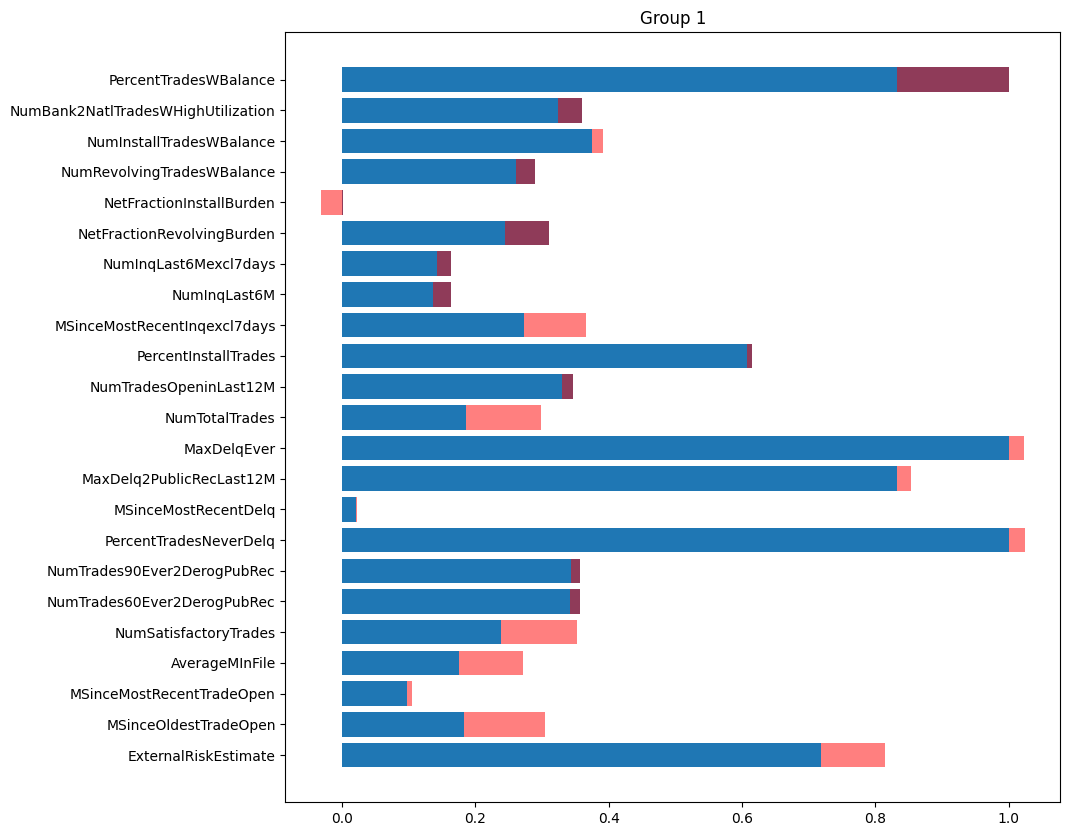

In [104]:
data_idx = 0

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title(f"Group {group_labels[data_idx]}")
ax.barh(cols, Xs_filtered[data_idx])
ax.barh(
    cols,
    D[group_labels[data_idx]] * M[data_idx],
    alpha=0.5,
    left=Xs_filtered[data_idx],
    color="red",
)